#**아래의 experiment_number 꼭 입력**

In [ ]:
experiment_number = 'ConvNeXt + InceptionV3 + Weighted CE' ### 자기 실험 번호 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm ptflops

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import scipy.io
import timm
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ptflops import get_model_complexity_info
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
!pip install torchprofile
from torchprofile import profile_macs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = '/content/drive/MyDrive/심층신경망개론/'

In [ ]:
seg_dir = os.path.join(data_dir, '102segmentations')

In [ ]:
setid = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))

train_ids = setid['trnid'][0]
valid_ids = setid['valid'][0]
test_ids = setid['tstid'][0]
image_labels = labels['labels'][0]

In [ ]:
def create_image_weight(seg_mask):
    seg_rgb = np.array(seg_mask)

    background = (seg_rgb[:, :, 0] == 0) & (seg_rgb[:, :, 1] == 0) & (seg_rgb[:, :, 2] == 0)

    flower_region = ~background
    flower_region = flower_region.astype(np.float32)

    flower_ratio = flower_region.mean()

    weight = 1.0 + (flower_ratio * 0.5)
    return float(weight)

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets, weights=None):
        loss = self.ce(inputs, targets)

        if weights is not None:
            loss = loss * weights

        return loss.mean()

class OxfordFlowersDataset(Dataset):
    def __init__(self, image_ids, labels, root_dir, seg_dir=None, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.seg_dir = seg_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'jpg', f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id - 1] - 1

        seg_mask = None
        if self.seg_dir is not None:
            seg_path = os.path.join(self.seg_dir, f'foreground_{img_id:05d}.png')
            if os.path.exists(seg_path):
                seg_mask = Image.open(seg_path).convert('RGB')
            else:
                w, h = image.size
                seg_mask = Image.new('RGB', (w, h), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        img_weight = 1.0
        if seg_mask is not None:
            img_weight = create_image_weight(seg_mask)

        return image, label, img_weight

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = OxfordFlowersDataset(train_ids, image_labels, data_dir, seg_dir=seg_dir, transform=train_transforms)
valid_dataset = OxfordFlowersDataset(valid_ids, image_labels, data_dir, seg_dir=seg_dir, transform=val_test_transforms)
test_dataset = OxfordFlowersDataset(test_ids, image_labels, data_dir, seg_dir=seg_dir, transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.aux_logits = False
in_features_inception = inception.fc.in_features
inception.fc = nn.Identity()

convnext = models.convnext_tiny(pretrained=True)
in_features_convnext = convnext.classifier[2].in_features
convnext.classifier[2] = nn.Identity()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception = inception.to(device)
convnext = convnext.to(device)

class CombinedModel(nn.Module):
    def __init__(self, inception, convnext, num_classes=102):
        super(CombinedModel, self).__init__()
        self.inception = inception
        self.convnext = convnext
        self.fc1 = nn.Linear(in_features_inception + in_features_convnext, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.745093574409461)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        f1 = self.inception(x)
        f2 = self.convnext(x)
        f = torch.cat([f1, f2], dim=1)
        f = self.fc1(f)
        f = self.bn1(f)
        f = self.relu(f)
        f = self.dropout(f)
        out = self.fc2(f)
        return out

model = CombinedModel(inception, convnext, num_classes=102).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 190MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated si

In [ ]:
dummy_input = torch.randn(1, 3, 299, 299).to(device)
flops = profile_macs(model, dummy_input)
print(f"FLOPs: {flops / 1e9:.4f} GFLOPs")

FLOPs: 13.2388 GFLOPs


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [ ]:
criterion = WeightedCrossEntropyLoss()

for param in model.inception.parameters():
    param.requires_grad = False
for param in model.convnext.parameters():
    param.requires_grad = False

trainable_params = list(model.fc1.parameters()) + \
                   list(model.bn1.parameters()) + \
                   list(model.fc2.parameters())

optimizer = torch.optim.AdamW(trainable_params, lr=0.0015240807648509965, weight_decay=3.432597361947343e-05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True,
    threshold=1e-4,
    threshold_mode='rel'
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
num_epochs = 20
patience = 3
best_val_loss = float('inf')
trigger_times = 0
unfreeze_epoch = 5

<ipython-input-17-e52125fc2efc>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
save_dir = f'/content/drive/MyDrive/심층신경망개론/model/'
os.makedirs(save_dir, exist_ok=True)

final_model_path = os.path.join(save_dir, f'{experiment_number}_model.pth')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

r_weight = 1.2
g_weight = 0.9
b_weight = 0.9

for epoch in range(num_epochs):
    if epoch == unfreeze_epoch:
        for param in model.inception.parameters():
            param.requires_grad = True
        for param in model.convnext.parameters():
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
        print(f"Unfrozen base layers at epoch: {epoch+1}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    for inputs, labels, img_weights in train_bar:
        inputs, labels, img_weights = inputs.to(device), labels.to(device), img_weights.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels, img_weights)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels_list = []

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():
        for val_inputs, val_labels, val_weights in val_bar:
            val_inputs, val_labels, val_weights = val_inputs.to(device), val_labels.to(device), val_weights.to(device)

            with autocast():
                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels, val_weights)

            val_loss += val_loss_batch.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels_list.extend(val_labels.cpu().numpy())

            val_bar.set_postfix(loss=val_loss_batch.item(), accuracy=100 * val_correct / val_total)

    val_epoch_loss = val_loss / len(valid_dataset)
    val_epoch_acc = 100 * val_correct / val_total

    val_accuracy = accuracy_score(all_labels_list, all_preds)
    val_precision = precision_score(all_labels_list, all_preds, average='macro')
    val_recall = recall_score(all_labels_list, all_preds, average='macro')
    val_f1 = f1_score(all_labels_list, all_preds, average='macro')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1-Score: {val_f1:.4f}\n')

    scheduler.step(val_epoch_loss)

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}\n')
        if trigger_times >= patience:
            print('Early stopping!\n')
            break

print("Training completed.")

Epoch 1/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Training: 100%|██████████| 32/32 [03:18<00:00,  6.21s/it, accuracy=11.1, loss=4.35]


Epoch [1/20], Train Loss: 5.0061, Train Accuracy: 11.08%


Epoch 1/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Validation: 100%|██████████| 32/32 [02:30<00:00,  4.71s/it, accuracy=57.2, loss=3.19]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 2.9896, Validation Accuracy: 57.16%
Validation Precision: 0.6273
Validation Recall: 0.5716
Validation F1-Score: 0.5342



Epoch 2/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, accuracy=47.9, loss=2.38]


Epoch [2/20], Train Loss: 2.8290, Train Accuracy: 47.94%


Epoch 2/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.39it/s, accuracy=82.3, loss=2.08]


Validation Loss: 1.8533, Validation Accuracy: 82.25%
Validation Precision: 0.8577
Validation Recall: 0.8225
Validation F1-Score: 0.8182



Epoch 3/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s, accuracy=68.6, loss=2.26]


Epoch [3/20], Train Loss: 1.8423, Train Accuracy: 68.63%


Epoch 3/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s, accuracy=85.5, loss=1.22]


Validation Loss: 1.2789, Validation Accuracy: 85.49%
Validation Precision: 0.8749
Validation Recall: 0.8549
Validation F1-Score: 0.8530



Epoch 4/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.01it/s, accuracy=77.1, loss=1.49]


Epoch [4/20], Train Loss: 1.3246, Train Accuracy: 77.06%


Epoch 4/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.19it/s, accuracy=87, loss=0.986]


Validation Loss: 1.0039, Validation Accuracy: 86.96%
Validation Precision: 0.8890
Validation Recall: 0.8696
Validation F1-Score: 0.8663



Epoch 5/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, accuracy=85.2, loss=0.778]


Epoch [5/20], Train Loss: 0.9353, Train Accuracy: 85.20%


Epoch 5/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s, accuracy=89.3, loss=0.54]


Validation Loss: 0.8214, Validation Accuracy: 89.31%
Validation Precision: 0.9025
Validation Recall: 0.8931
Validation F1-Score: 0.8915

Unfrozen base layers at epoch: 6


Epoch 6/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s, accuracy=88.5, loss=0.857]


Epoch [6/20], Train Loss: 0.7297, Train Accuracy: 88.53%


Epoch 6/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, accuracy=90.4, loss=0.462]


Validation Loss: 0.7218, Validation Accuracy: 90.39%
Validation Precision: 0.9150
Validation Recall: 0.9039
Validation F1-Score: 0.9023



Epoch 7/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, accuracy=91.2, loss=0.615]


Epoch [7/20], Train Loss: 0.6440, Train Accuracy: 91.18%


Epoch 7/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s, accuracy=90.7, loss=0.43]


Validation Loss: 0.6990, Validation Accuracy: 90.69%
Validation Precision: 0.9169
Validation Recall: 0.9069
Validation F1-Score: 0.9049



Epoch 8/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, accuracy=91.6, loss=0.505]


Epoch [8/20], Train Loss: 0.5899, Train Accuracy: 91.57%


Epoch 8/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s, accuracy=90.8, loss=0.43]


Validation Loss: 0.6731, Validation Accuracy: 90.78%
Validation Precision: 0.9169
Validation Recall: 0.9078
Validation F1-Score: 0.9060



Epoch 9/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s, accuracy=92.5, loss=0.816]


Epoch [9/20], Train Loss: 0.5516, Train Accuracy: 92.55%


Epoch 9/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, accuracy=91.1, loss=0.433]


Validation Loss: 0.6582, Validation Accuracy: 91.08%
Validation Precision: 0.9194
Validation Recall: 0.9108
Validation F1-Score: 0.9092



Epoch 10/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.00it/s, accuracy=92.5, loss=0.34]


Epoch [10/20], Train Loss: 0.5307, Train Accuracy: 92.45%


Epoch 10/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s, accuracy=91.9, loss=0.401]


Validation Loss: 0.6299, Validation Accuracy: 91.86%
Validation Precision: 0.9272
Validation Recall: 0.9186
Validation F1-Score: 0.9176



Epoch 11/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, accuracy=93, loss=0.435]


Epoch [11/20], Train Loss: 0.5099, Train Accuracy: 93.04%


Epoch 11/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.44it/s, accuracy=91.9, loss=0.407]


Validation Loss: 0.6180, Validation Accuracy: 91.86%
Validation Precision: 0.9265
Validation Recall: 0.9186
Validation F1-Score: 0.9175



Epoch 12/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s, accuracy=93.8, loss=0.403]


Epoch [12/20], Train Loss: 0.4785, Train Accuracy: 93.82%


Epoch 12/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, accuracy=92.5, loss=0.413]


Validation Loss: 0.5996, Validation Accuracy: 92.45%
Validation Precision: 0.9326
Validation Recall: 0.9245
Validation F1-Score: 0.9237



Epoch 13/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.92it/s, accuracy=94.9, loss=0.424]


Epoch [13/20], Train Loss: 0.4564, Train Accuracy: 94.90%


Epoch 13/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.02it/s, accuracy=92.8, loss=0.404]


Validation Loss: 0.5853, Validation Accuracy: 92.84%
Validation Precision: 0.9364
Validation Recall: 0.9284
Validation F1-Score: 0.9276



Epoch 14/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, accuracy=95.6, loss=0.31]


Epoch [14/20], Train Loss: 0.4163, Train Accuracy: 95.59%


Epoch 14/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s, accuracy=92.6, loss=0.37]


Validation Loss: 0.5792, Validation Accuracy: 92.65%
Validation Precision: 0.9354
Validation Recall: 0.9265
Validation F1-Score: 0.9260



Epoch 15/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.93it/s, accuracy=95.4, loss=0.421]


Epoch [15/20], Train Loss: 0.4202, Train Accuracy: 95.39%


Epoch 15/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.39it/s, accuracy=92.6, loss=0.367]


Validation Loss: 0.5725, Validation Accuracy: 92.65%
Validation Precision: 0.9348
Validation Recall: 0.9265
Validation F1-Score: 0.9259



Epoch 16/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, accuracy=97.5, loss=0.499]


Epoch [16/20], Train Loss: 0.3558, Train Accuracy: 97.45%


Epoch 16/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, accuracy=92.5, loss=0.37]


Validation Loss: 0.5609, Validation Accuracy: 92.55%
Validation Precision: 0.9335
Validation Recall: 0.9255
Validation F1-Score: 0.9245



Epoch 17/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, accuracy=96.5, loss=0.413]


Epoch [17/20], Train Loss: 0.3693, Train Accuracy: 96.47%


Epoch 17/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, accuracy=93.1, loss=0.364]


Validation Loss: 0.5471, Validation Accuracy: 93.14%
Validation Precision: 0.9384
Validation Recall: 0.9314
Validation F1-Score: 0.9308



Epoch 18/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.06it/s, accuracy=96.6, loss=0.443]


Epoch [18/20], Train Loss: 0.3596, Train Accuracy: 96.57%


Epoch 18/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Validation: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, accuracy=92.5, loss=0.359]


Validation Loss: 0.5420, Validation Accuracy: 92.55%
Validation Precision: 0.9327
Validation Recall: 0.9255
Validation F1-Score: 0.9244



Epoch 19/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.09it/s, accuracy=97.8, loss=0.274]


Epoch [19/20], Train Loss: 0.3230, Train Accuracy: 97.84%


Epoch 19/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, accuracy=93.4, loss=0.366]


Validation Loss: 0.5286, Validation Accuracy: 93.43%
Validation Precision: 0.9411
Validation Recall: 0.9343
Validation F1-Score: 0.9341



Epoch 20/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Training: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, accuracy=97.5, loss=0.312]


Epoch [20/20], Train Loss: 0.3324, Train Accuracy: 97.45%


Epoch 20/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-18-3ecc512c6174>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Validation: 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, accuracy=93.7, loss=0.334]


Validation Loss: 0.5201, Validation Accuracy: 93.73%
Validation Precision: 0.9436
Validation Recall: 0.9373
Validation F1-Score: 0.9370

Training completed.


<ipython-input-19-27183f2176bf>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path))


Error loading the final model: [Errno 2] No such file or directory: '/content/drive/MyDrive/심층신경망개론/model/6번_model.pth'


Testing:   0%|          | 0/193 [00:00<?, ?it/s]<ipython-input-19-27183f2176bf>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 193/193 [15:50<00:00,  4.93s/it, accuracy=91.25%, loss=0.0642, top5_accuracy=97.85%]


Test Loss: 0.6249, Top-1 Accuracy: 91.25%, Top-5 Accuracy: 97.85%
Test Precision: 0.9048
Test Recall: 0.9294
Test F1-Score: 0.9125


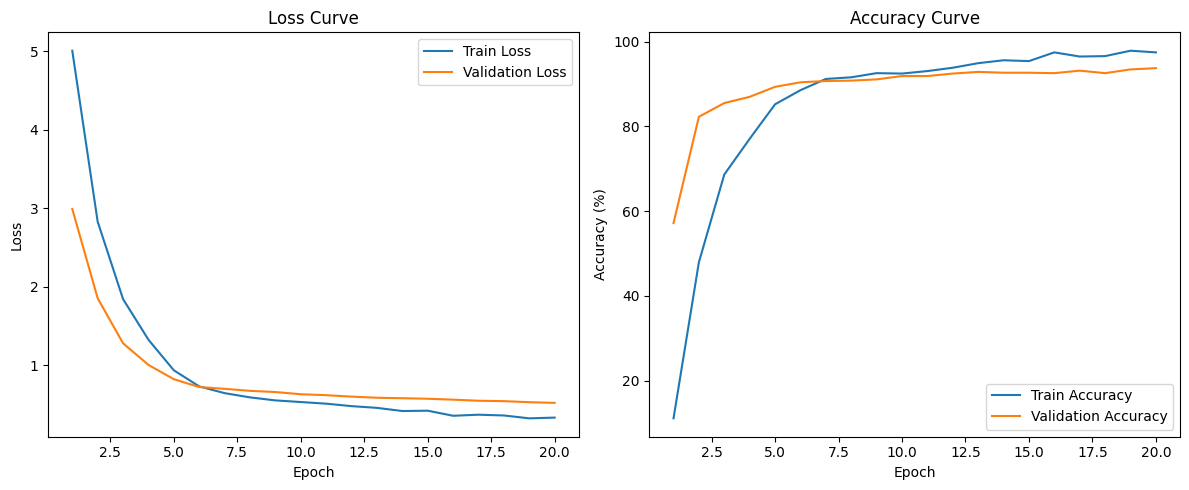

[5.006088714142631, 2.829021031810713, 1.8423375603698042, 1.3246375436489646, 0.9352942549735754, 0.7296743926073893, 0.6440492289813338, 0.5899440488885244, 0.5515849179029737, 0.5307232103284458, 0.5098826504619167, 0.47845787463568834, 0.45638523583528856, 0.416337508506399, 0.4202457514250204, 0.3557984205536038, 0.36926017654377924, 0.3596142094943331, 0.3229888432769249, 0.3323774266120941]
[11.07843137254902, 47.94117647058823, 68.62745098039215, 77.05882352941177, 85.19607843137256, 88.52941176470588, 91.17647058823529, 91.56862745098039, 92.54901960784314, 92.45098039215686, 93.03921568627452, 93.82352941176471, 94.90196078431373, 95.58823529411765, 95.3921568627451, 97.45098039215686, 96.47058823529412, 96.56862745098039, 97.84313725490196, 97.45098039215686]
[2.9895868439276, 1.8533198726494224, 1.278919035557704, 1.003861435110115, 0.821359606192529, 0.7218308006390028, 0.6990077860182298, 0.6730599541596199, 0.6581977391752311, 0.6299276246047915, 0.6180428508703023, 0.59

In [ ]:
from sklearn.metrics import top_k_accuracy_score

try:
    model.load_state_dict(torch.load(final_model_path))
    print(f'Loaded final model from {final_model_path}')
except Exception as e:
    print(f'Error loading the final model: {e}')

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_correct_top5 = 0

test_all_preds = []
test_all_labels = []
test_all_probs = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Testing")

    for test_inputs, test_labels, test_weights in test_bar:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_weights = test_weights.to(device)

        with autocast():
            test_outputs = model(test_inputs)
            test_loss_batch = criterion(test_outputs, test_labels, test_weights)

        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

        top5_probs, top5_predicted = torch.topk(test_outputs, 5, dim=1)
        test_correct_top5 += torch.sum(top5_predicted.eq(test_labels.view(-1, 1).expand_as(top5_predicted))).item()

        test_all_preds.extend(test_predicted.cpu().numpy())
        test_all_labels.extend(test_labels.cpu().numpy())

        test_all_probs.extend(torch.softmax(test_outputs, dim=1).cpu().numpy())

        current_accuracy = 100 * test_correct / test_total
        current_top5_accuracy = 100 * test_correct_top5 / test_total
        test_bar.set_postfix(loss=test_loss_batch.item(),
                             accuracy=f"{current_accuracy:.2f}%",
                             top5_accuracy=f"{current_top5_accuracy:.2f}%")

test_epoch_loss = test_loss / len(test_dataset)
test_epoch_acc = 100 * test_correct / test_total
test_epoch_top5_acc = 100 * test_correct_top5 / test_total

test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_precision = precision_score(test_all_labels, test_all_preds, average='macro')
test_recall = recall_score(test_all_labels, test_all_preds, average='macro')
test_f1 = f1_score(test_all_labels, test_all_preds, average='macro')

print('Test Loss: {:.4f}, Top-1 Accuracy: {:.2f}%, Top-5 Accuracy: {:.2f}%'.format(
    test_epoch_loss, test_epoch_acc, test_epoch_top5_acc))
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)